In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Stock Model/HistoricalData_1705114647193.csv')

df['Date'] = pd.to_datetime(df['Date'])
df['Close/Last'] = df['Close/Last'].str.replace('$', '', regex=False)
df['Open'] = df['Open'].str.replace('$', '', regex=False)
df['High'] = df['High'].str.replace('$', '', regex=False)
df['Low'] = df['Low'].str.replace('$', '', regex=False)

In [3]:
# non-trading days (verified mostly weekends)
missing_dates = df.set_index('Date').asfreq('D').index[df.set_index('Date').asfreq('D').isnull().any(axis=1)]

In [4]:
df = df.sort_values(by = 'Date')

In [5]:
df.rename(columns={'Close/Last': 'Close'}, inplace=True)

In [6]:
df['Close'] = df['Close'].astype(float)
df['Open'] = df['Open'].astype(float)
df['High'] = df['High'].astype(float)
df['Low'] = df['Low'].astype(float)

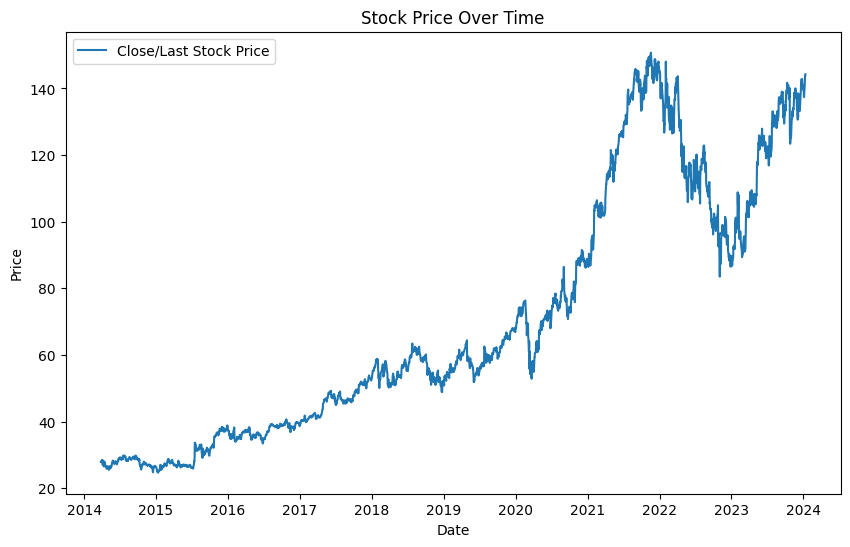

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Close'], label='Close/Last Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Price Over Time')
plt.legend()
plt.show()

In [8]:
df['Tomorrow'] = df['Close'].shift(-1)

In [9]:
df = df.dropna()

In [10]:
df['Target'] = (df['Tomorrow'] > df['Close']).astype(int)

In [11]:
df2 = df.copy()

In [12]:
df3 = df.copy()

##Model

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score

# non linear relationships, Target: [0,1]
# categorical variables
# bootstrap (using different data for every decision tree, allowing model to be less sensitive to training data; reduce correlation between different trees, reduce variance) +
# aggregation

In [14]:
model = RandomForestClassifier(n_estimators=100, random_state= 1, min_samples_split= 100)
train = df.iloc[:-251]
test = df.iloc[-251:]
predictors = ['Close', 'Volume','Open','High','Low']
model.fit(train[predictors],train['Target'])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [15]:
preds = model.predict(test[predictors])
pred = pd.Series(preds, index=test.index)
precision_score(test["Target"], pred)

0.5086705202312138

In [16]:
# prediction function that returns a data frame with predicted target values vs. actual target values
def predict(test, train, predictors, model):
  model.fit(train[predictors],train['Target'])
  preds = model.predict(test[predictors])
  preds = pd.Series(preds, index=test.index, name="Predictions")
  combined = pd.concat([test["Target"], preds], axis=1)
  return combined

In [17]:
def backtest(data, model, predictors, start=753, step=251):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy() #starting from first 753 days
        test = data.iloc[i:(i+step)].copy() #testing starting days + 251 days
        # .copy() to avoid copy warning
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)

In [18]:
predictions_bt = backtest(df, model, predictors)

In [19]:
predictions_bt["Predictions"].value_counts()

1    8322
0    2220
Name: Predictions, dtype: int64

In [20]:
rf_ps = precision_score(predictions_bt["Target"], predictions_bt["Predictions"])

In [40]:
rf_ps - 0.5086705202312138

0.01944772057628441

In [21]:
# natural percentage of days the stock went up
predictions_bt["Target"].value_counts() / predictions_bt.shape[0]

1    0.529311
0    0.470689
Name: Target, dtype: float64

###Moving Averages

In [22]:
# adding moving-average columns
horizons = [2,5,60,100,250,500]

In [23]:
new_predictors = []

# Simple Moving Average (SMA) identifies market trends, entry/exit points, confidence levels
# P/MA replicates that idea

for horizon in horizons:
    rolling_averages = df.rolling(horizon).mean() # a data frame with moving averages

    ratio_column = f"Close_Ratio_{horizon}"
    df[ratio_column] = df["Close"] / rolling_averages["Close"]

    trend_column = f"Trend_{horizon}"
    df[trend_column] = df.shift(1).rolling(horizon).sum()["Target"]

    new_predictors+= [ratio_column, trend_column]

<ipython-input-23-b873e64a5b6b>:7: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['Date'], dtype='object')
  rolling_averages = df.rolling(horizon).mean() # a data frame with moving averages
<ipython-input-23-b873e64a5b6b>:13: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['Date'], dtype='object')
  df[trend_column] = df.shift(1).rolling(horizon).sum()["Target"]
<ipython-input-23-b873e64a5b6b>:7: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['Date'], dtype='object')
  rolling_averages = df.rolling(h

In [24]:
df = df.dropna(subset=df.columns[df.columns != "Tomorrow"])

In [25]:
model2 = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [26]:
def predict2(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1] # taking second column returns probability of stock going up
    preds[preds >=.6] = 1 # increases certainty of stock going up
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [27]:
def backtest2(data, model, predictors, start=753, step=251):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy() #starting from first 753 days
        test = data.iloc[i:(i+step)].copy() #testing starting days + 251 days
        # .copy() to avoid copy warning
        predictions = predict2(train, test, predictors, model)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)

In [28]:
predictions2 = backtest2(df, model2, new_predictors)

In [29]:
predictions2["Predictions"].value_counts()

0.0    976
1.0    237
Name: Predictions, dtype: int64

In [30]:
ma_ps = precision_score(predictions2["Target"], predictions2["Predictions"])

###Simple Moving Average (SMA)

In [31]:
df2['sma_s'] = df2['Close'].rolling(20).mean()
df2['sma_l'] = df2['Close'].rolling(50).mean()
df2['vwma_s'] = (df2['Close'] * df2['Volume']).rolling(20).sum() / df2['Volume'].rolling(20).sum()
df2['vwma_l'] = (df2['Close'] * df2['Volume']).rolling(50).sum() / df2['Volume'].rolling(50).sum()

In [32]:
df2 = df2.dropna()

In [33]:
df2.head()

,Date,Close,Volume,Open,High,Low,Tomorrow,Target,sma_s,sma_l,vwma_s,vwma_l
2417,2014-06-06,27.8165,34639660,27.9030,27.9030,27.4465,28.1060,1,27.114225,26.98490,27.118960,26.928055
2416,2014-06-09,28.1060,29216640,27.8575,28.1450,27.8020,28.0275,0,27.222700,26.98856,27.251685,26.943105
2415,2014-06-10,28.0275,26920360,28.0255,28.1800,27.8950,27.9420,0,27.299275,26.98912,27.329410,26.955443
2414,2014-06-11,27.9420,21928260,27.9000,27.9940,27.7510,27.5675,0,27.363650,26.99099,27.386140,26.964696
2413,2014-06-12,27.5675,29085600,27.8650,27.8995,27.4230,27.5880,1,27.425400,26.97518,27.433978,26.972074


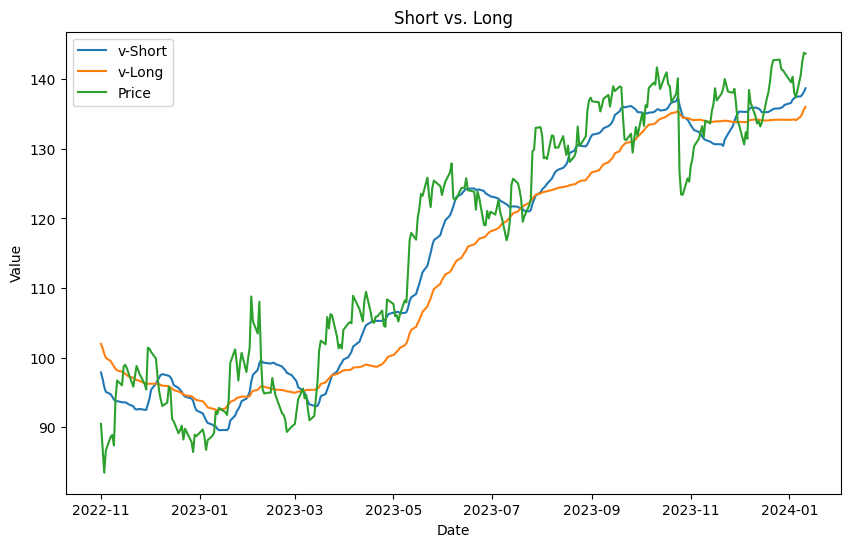

In [34]:
# short crosses above long -> upward trend
plt.figure(figsize=(10, 6))
plt.plot(df2['Date'].iloc[-300:], df2['vwma_s'].iloc[-300:], label='v-Short')
plt.plot(df2['Date'].iloc[-300:], df2['vwma_l'].iloc[-300:], label='v-Long')
plt.plot(df2['Date'].iloc[-300:], df2['Close'].iloc[-300:], label='Price')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Short vs. Long')
plt.legend()

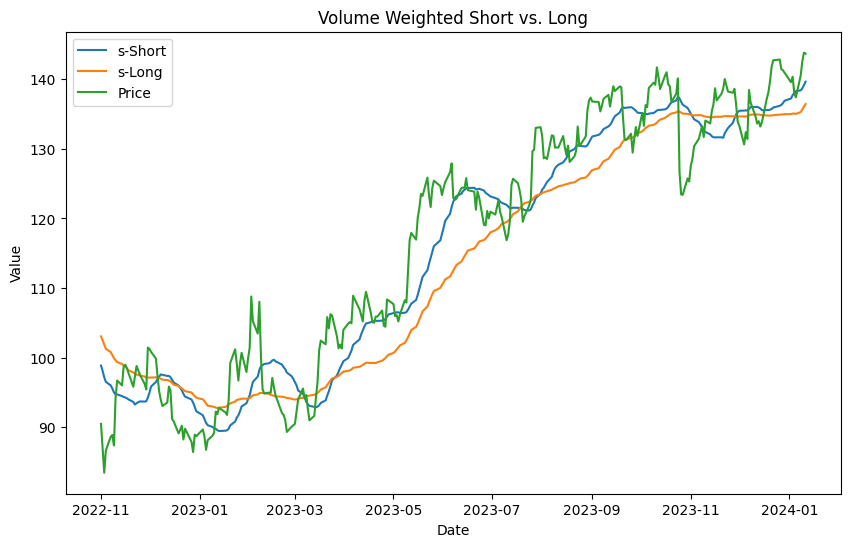

In [35]:
plt.figure(figsize=(10, 6))
plt.plot(df2['Date'].iloc[-300:], df2['sma_s'].iloc[-300:], label='s-Short')
plt.plot(df2['Date'].iloc[-300:], df2['sma_l'].iloc[-300:], label='s-Long')
plt.plot(df2['Date'].iloc[-300:], df2['Close'].iloc[-300:], label='Price')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Volume Weighted Short vs. Long')
plt.legend()

In [36]:
# understanding whether the stock closed closer to the high or low value of the day
# not sensitive to stock splits
df2['Normalized Value'] = (df2['Close'] - df2['Low'])/(df2['High'] - df2['Low'])

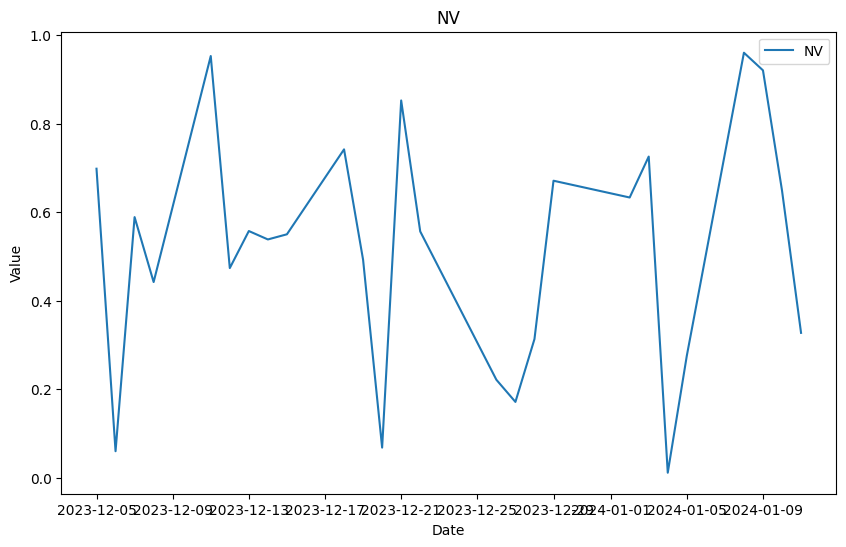

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(df2['Date'].iloc[-26:], df2['Normalized Value'].iloc[-26:], label='NV')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('NV')
plt.legend()

### LSTM

In [38]:
df3 = df3[['Date', 'Close']]